In [140]:
libraries = c("dplyr", "tidyverse", "magrittr")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

options(scipen=10000)
theme_set(theme_bw())
version$version.string

[1] "R version 4.2.2 (2022-10-31)"

In [187]:
read.csv("../data/df_inci_final_WHO_backproj.csv") -> df_inci
read.csv("../data/SAR_cip_Reff_excess.csv") -> df_CFOI
read.csv("../data/SAR_finalsize.csv") -> df_CFOI_final
read.csv("../data/flight/flight_matrix_depart_random.csv") -> flight_matrix_depart_thres

In [188]:
df_CFOI %<>% mutate(n_raw=n/1000000) %>% dplyr::select(-n) %>% rename(n=n_raw)

In [189]:
## fixed parameters
w <- 14
SAR_list <- c(0.2, 0.3, 0.4)
time_0 <- as.Date("2022-04-17")
time_end <- as.Date("2022-10-01")

In [190]:
## extrapolating CFOI (i.e., linear extrapolation with the cumulative incidence among MSM population)
merge(df_inci %>% dplyr::select(cum_icni_prop) %>% rename(Infections=cum_icni_prop), 
      df_CFOI %>% dplyr::select(Infections, n), by=c("Infections"), all.x=TRUE) %>% 
arrange(Infections) %>% distinct() -> temp_df_CFOI
temp_df_CFOI[rowSums(is.na(temp_df_CFOI))>0,] -> temp_df_CFOI_NA

for(i in 1:nrow(temp_df_CFOI_NA)){
    c(min(df_CFOI$Infections[which(df_CFOI$Infections>temp_df_CFOI_NA$Infections[i])]),
      min(df_CFOI$Infections[which(df_CFOI$Infections<temp_df_CFOI_NA$Infections[i])])) -> two_val
    sort(two_val) -> two_val
    
    df_CFOI %>% filter(Infections >= two_val[1] & Infections <= two_val[2]) %>% 
    dplyr::select(Infections, n) -> temp
    
    approx(temp$Infections, temp$n, 
           xout = temp_df_CFOI_NA$Infections[i], method="linear")$y -> temp_df_CFOI_NA[i,2]
}

temp_df_CFOI_NA %<>% mutate(X=NA, SAR=NA, Reff_1=NA, Reff_2=NA, Excess=NA) %>% 
dplyr::select(X, SAR, Infections, Reff_1, Reff_2, Excess, n)

rbind(df_CFOI, temp_df_CFOI_NA) %>% arrange(Infections) -> df_CFOI_extra

In [191]:
## Reff_i & G_i (fixing the country name issue)
merge(df_inci, df_CFOI_extra %>% dplyr::select(Infections, n) %>% rename(cum_icni_prop=Infections),
      by=c("cum_icni_prop"), all.x=TRUE) %>% rename(CFOI_t=n) %>%
mutate(location=case_when(location==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                          location==c("Curaçao")~c("Curacao"),
                          location==c("Czechia")~c("Czech Republic"),
                          location==c("Türkiye")~c("Turkey"),
                          location==c("Iran")~c("Iran, Islamic Republic of"),
                          location==c("Republic of Korea")~c("Korea, Republic of"),
                          location==c("United States")~c("United States of America"),
                          location==c("Venezuela (Bolivarian Republic of)")~c("Venezuela, Bolivarian Republic of"),
                          location==c("Republic of Moldova")~c("Moldova, Republic of"),
                          location==c("Russia")~c("Russian Federation"),
                          location==c("Bolivia")~c("Bolivia, Plurinational State of"),
                          location==c("Hong Kong")~c("Hong Kong, China"),
                          location==c("Taiwan")~c("Taiwan, Province of China"),
                          location==c("Republic of Congo") ~ c("Congo"),
                          location==c("Bosnia And Herzegovina") ~ c("Bosnia and Herzegovina"),
                          location==c("The United Kingdom") ~ c("United Kingdom"),
                          location==c("Russia") ~ c("Russian Federation"),
                          TRUE~location)) %>%
filter(!(location %in% c("Gibraltar", "Greenland", "Saint Martin"))) -> input

as.Date(input$date) -> input$date

input_list <- list()
for(i in 1:length(SAR_list)){
    input %>% mutate(time=as.numeric(date-time_0+1), censoring=0) %>% arrange(date) %>% dplyr::select(-X) %>%
    mutate(CFOI_final = df_CFOI_final %>% filter(SAR==SAR_list[[i]]) %>% 
           dplyr::select(cfoi_final) %>% as.numeric()) -> input_list[[i]]
}

In [192]:
## MSM population size data
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize_Fumi.csv") -> df_MSM2

## revising the pop2022 column from df_MSM2
read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, location=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

# modifying India data with the AIDS Data Hub slide
df_MSM1 %<>% filter(!location==c("India"))

## giving a priority to UNAIDS dashboard
merge(df_MSM1, df_MSM2, by=c("location"), all=TRUE) %>% 
dplyr::select(location, iso_code, estimate, MSM_size, region, sub_region, pop2022, MSM_percent) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_percent*0.01*pop2022), 
       prop=imputed/pop2022*100) -> temp

## imputation of missing values
df_MSM2 %>% filter(!is.na(MSM_percent)) %>% dplyr::select(sub_region, MSM_percent) %>% 
rename(prop_med=MSM_percent) %>% distinct() -> prop_med 
temp %>% filter(sub_region %in% c("Northern America","Northern Europe","Southern Europe","Western Europe")) %>% 
group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_med = median(prop)) -> prop_med2
rbind(prop_med, prop_med2) -> prop_med_all

merge(temp, prop_med_all, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_med),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*0.01*pop2022)) -> df_MSM_imputed

## modifying Samoa data with the value from UNAIDS reports
df_MSM_imputed %>% mutate(imputed=case_when(location==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(location==c("Samoa")~MSM_size/pop2022*100, TRUE~prop)) -> df_MSM_imputed

In [193]:
## calculating Reff_i & G_i in countries without MPX importation
unique(input$location) -> country_list; sort(country_list) -> country_list_sort

flight_matrix_depart_thres %<>% 
mutate(departure=case_when(departure==c("Micronesia (Federated States Of)")~c("Micronesia, Federated States of"),
                           departure==c("Swaziland")~c("Eswatini"),
                           departure==c("Libyan Arab Jamahiriya")~c("Libya"),
                           departure==c("Cape Verde")~c("Cabo Verde"), 
                           departure==c("Lao People\'s Democratic Republic")~c("Lao People's Democratic Republic"),
                           TRUE~departure))
setdiff(flight_matrix_depart_thres$departure, country_list_sort) -> country_no_list_sort
sort(country_no_list_sort) -> country_no_list_sort

as.data.frame(country_no_list_sort) %>% rename(location=country_no_list_sort) -> country_no_import

df_MSM_imputed %>%
mutate(location=case_when(location==c("Côte d\'Ivoire")~c("Cote d'Ivoire"),
                          location==c("Macao")~c("Macao, China"),
                          location==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                          location==c("Saint Vincent and the Grenadines")~c("Saint Vincent and The Grenadines"),
                          location==c("Virgin Islands (U.S.)")~c("United States Virgin Islands"),
                          location==c("Virgin Islands (British)")~c("British Virgin Islands"),
                          location==c("Korea (Democratic People\'s Republic of)")~c("Korea, Democratic Peoples Republic of"),
                          location==c("Réunion")~c("Reunion"),
                          location==c("Lao People\'s Democratic Republic")~c("Lao People's Democratic Republic"),
                          TRUE~location)) -> df_MSM_imputed

merge(country_no_import, df_MSM_imputed %>% dplyr::select(location, iso_code, imputed, pop2022, region, sub_region), 
      by=c("location"), all.x=TRUE) -> country_no_import_pop

df_inci_no_list <- list()

as.data.frame(seq(min(input$date), max(input$date),1)) -> temp_cal
colnames(temp_cal) <- c("date")
unique(country_no_import_pop$location) -> no_list

input_no_list <- list()
for(g in 1:length(SAR_list)){
    for(i in 1:length(no_list)){
        country_no_import_pop %>% filter(location==no_list[i]) %>% mutate(date=min(input$date))-> temp_inci
        merge(temp_cal, temp_inci, by=c("date"), all.x=TRUE) %>% 
        mutate(new_cases=NA, total_cases=NA, MA_new_cases=NA, MA_total_cases=NA, 
               date_import=NA, import_low=NA, import_upp=NA, cum_icni_prop=NA, CFOI_t=0,
               CFOI_final=df_CFOI_final %>% filter(SAR==SAR_list[[g]]) %>% 
               dplyr::select(cfoi_final) %>% as.numeric()) -> temp_inci_all

        temp_inci_all$location[is.na(temp_inci_all$location)] <- unique(temp_inci$location)
        temp_inci_all$iso_code[is.na(temp_inci_all$iso_code)] <- unique(temp_inci$iso_code)
        temp_inci_all$region[is.na(temp_inci_all$region)] <- unique(temp_inci$region)
        temp_inci_all$sub_region[is.na(temp_inci_all$sub_region)] <- unique(temp_inci$sub_region)
        temp_inci_all$new_cases[is.na(temp_inci_all$new_cases)] <- 0
        temp_inci_all$total_cases[is.na(temp_inci_all$total_cases)] <- 0
        temp_inci_all$MA_new_cases[is.na(temp_inci_all$MA_new_cases)] <- 0
        temp_inci_all$MA_total_cases[is.na(temp_inci_all$MA_total_cases)] <- 0
        temp_inci_all$cum_icni_prop[is.na(temp_inci_all$cum_icni_prop)] <- 0
        temp_inci_all$pop2022[is.na(temp_inci_all$pop2022)] <- unique(temp_inci$pop2022)
        temp_inci_all$imputed[is.na(temp_inci_all$imputed)] <- unique(temp_inci$imputed)

        temp_inci_all %>% dplyr::select(iso_code, location, date, new_cases, total_cases, 
                                        MA_new_cases, MA_total_cases, date_import, import_low, import_upp,
                                        imputed, pop2022, region, sub_region, cum_icni_prop, CFOI_t, CFOI_final) %>%
        mutate(MSM_pop=imputed*100) %>% dplyr::select(-imputed) -> temp_inci_all

        temp_inci_all -> df_inci_no_list[[i]]    
    }

    do.call("rbind", df_inci_no_list) %>% as.data.frame() %>% arrange(location, date) %>%
    mutate(time=as.numeric(date-time_0+1), censoring=1) -> input_no_list[[g]]   
}

In [194]:
input_all_list <- list()
for (i in 1:length(SAR_list)){
    rbind(input_list[[i]], input_no_list[[i]]) -> input_all_list[[i]]
    input_all_list[[i]] %>% filter(date <= time_end) %>% 
    mutate(diff_CFOI=CFOI_final-CFOI_t) -> input_all_list[[i]]
}

In [195]:
## countries without travel volume data
unique(input_all_list[[1]]$location) -> country_list
country_list <- country_list[!country_list %in% c("Sudan", "Ghana", "Liberia", "Congo", "Nigeria", "Cameroon", 
                                                  "Congo, Democratic Republic of the", "Central African Republic")]
sort(country_list) -> country_list_sort
setdiff(country_list_sort, flight_matrix_depart_thres$departure)

character(0)

In [196]:
## calculating exporting capacity
C_i_final <- list(); C_i_time_list <- list()

for(k in 1:length(SAR_list)){
    for(i in 1:length(country_list_sort)){
        flight_matrix_depart_thres %>% filter(departure==country_list_sort[i]) %>% 
        dplyr::select(-c("departure","X")) -> temp
        sum(temp) -> V_ji_temp

        input_all_list[[k]] %>% filter(location==country_list_sort[i])%>%  
        mutate(C_i_t=w/365*V_ji_temp*diff_CFOI*MSM_pop/(pop2022*1000)) -> C_i_time_list[[i]]
    }
    do.call("rbind", C_i_time_list) %>% as.data.frame() %>% mutate(SAR=SAR_list[k]) -> C_i_final[[k]]
}

do.call("rbind", C_i_final) %>% as.data.frame() %>%
mutate(group=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"),
                       TRUE ~ region)) %>%
mutate(date_import=case_when(date_import==NA ~ as.Date("2022-12-08"))) -> C_i_final_all

In [197]:
library("rworldmap")
capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% filter(SAR==0.2 & date == as.Date("2022-05-15")) %>%
                                     dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
exporting_map_poly <- fortify(exporting_map)
exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
exporting_map_poly2 <- exporting_map_poly %>% arrange(id, order)

capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% filter(SAR==0.2 & date == as.Date("2022-07-15")) %>%
                                     dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
exporting_map_poly <- fortify(exporting_map)
exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
exporting_map_poly6 <- exporting_map_poly %>% arrange(id, order)


capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% filter(SAR==0.2 & date == as.Date("2022-09-15")) %>%
                                     dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
exporting_map_poly <- fortify(exporting_map)
exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
exporting_map_poly10 <- exporting_map_poly %>% arrange(id, order)

Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


In [243]:
C_i_final_all %>% filter(SAR==0.2) -> C_i_figure

scale_set <- scales::rescale(c(0, 250, 550, 700, 850, 1200, 1400, max(C_i_figure$C_i_t)),
                       from = c(min(C_i_figure$C_i_t), max(C_i_figure$C_i_t)))
limit_set <- c(min(C_i_figure$C_i_t), max(C_i_figure$C_i_t))
colort_set <- c('#fff8ba', '#fcdba2', '#f4a77a', '#e18079', '#c35e7d', '#9b4283', '#6c2d83', "#4f0e69")
label_set = c("500", "1000", "1500")
break_set = c(500, 1000, 1500)

options(repr.plot.width=10,repr.plot.height=5)
ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = exporting_map_poly2, aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Export capacity of mpox on 15 May 2022") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15May

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = exporting_map_poly6, aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Export capacity of mpox on 15 July 2022") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Jul

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = exporting_map_poly10, aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Export capacity of mpox on 15 September 2022") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep

library(ggpubr)
options(repr.plot.width=11,repr.plot.height=15)

ggarrange(Fig15May, Fig15Jul, Fig15Sep, 
          labels = c("D","E","F"), font.label = list(size = 25), vjust=1.2, hjust=0.055,
          ncol = 1, nrow = 3, common.legend = TRUE, legend="right") -> Fig_export2

In [244]:
C_i_final_all %>% filter(SAR==0.2) -> C_i_figure

scale_set <- scales::rescale(c(0, 3000, 6500, 10000, 15000, 18000, 22000, max(C_i_figure$MA_total_cases)),
                       from = c(min(C_i_figure$MA_total_cases), max(C_i_figure$MA_total_cases)))
limit_set <- c(min(C_i_figure$MA_total_cases), max(C_i_figure$MA_total_cases))
colort_set <- c('#fff8ba', '#fcdba2', '#f4a77a', '#e18079', '#c35e7d', '#9b4283', '#6c2d83', "#4f0e69")
label_set = c("5000", "15000", "25000")
break_set = c(5000, 15000, 25000)

options(repr.plot.width=10,repr.plot.height=5)
ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = exporting_map_poly2, aes(long, lat, group = group, fill=MA_total_cases),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Cumulative cases", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Cumulative reported mpox cases as of 15 May 2022") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15May

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = exporting_map_poly6, aes(long, lat, group = group, fill=MA_total_cases),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Cumulative cases", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Cumulative reported mpox cases as of 15 July 2022") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Jul

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = exporting_map_poly10, aes(long, lat, group = group, fill=MA_total_cases),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Cumulative cases", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Cumulative reported mpox cases as of 15 September 2022") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep

library(ggpubr)
options(repr.plot.width=11,repr.plot.height=15)
ggarrange(Fig15May, Fig15Jul, Fig15Sep, 
          labels = c("A","B","C"), font.label = list(size = 25), vjust=1.2, hjust=0.055,
          ncol = 1, nrow = 3, common.legend = TRUE, legend="right") -> Fig_cumcase

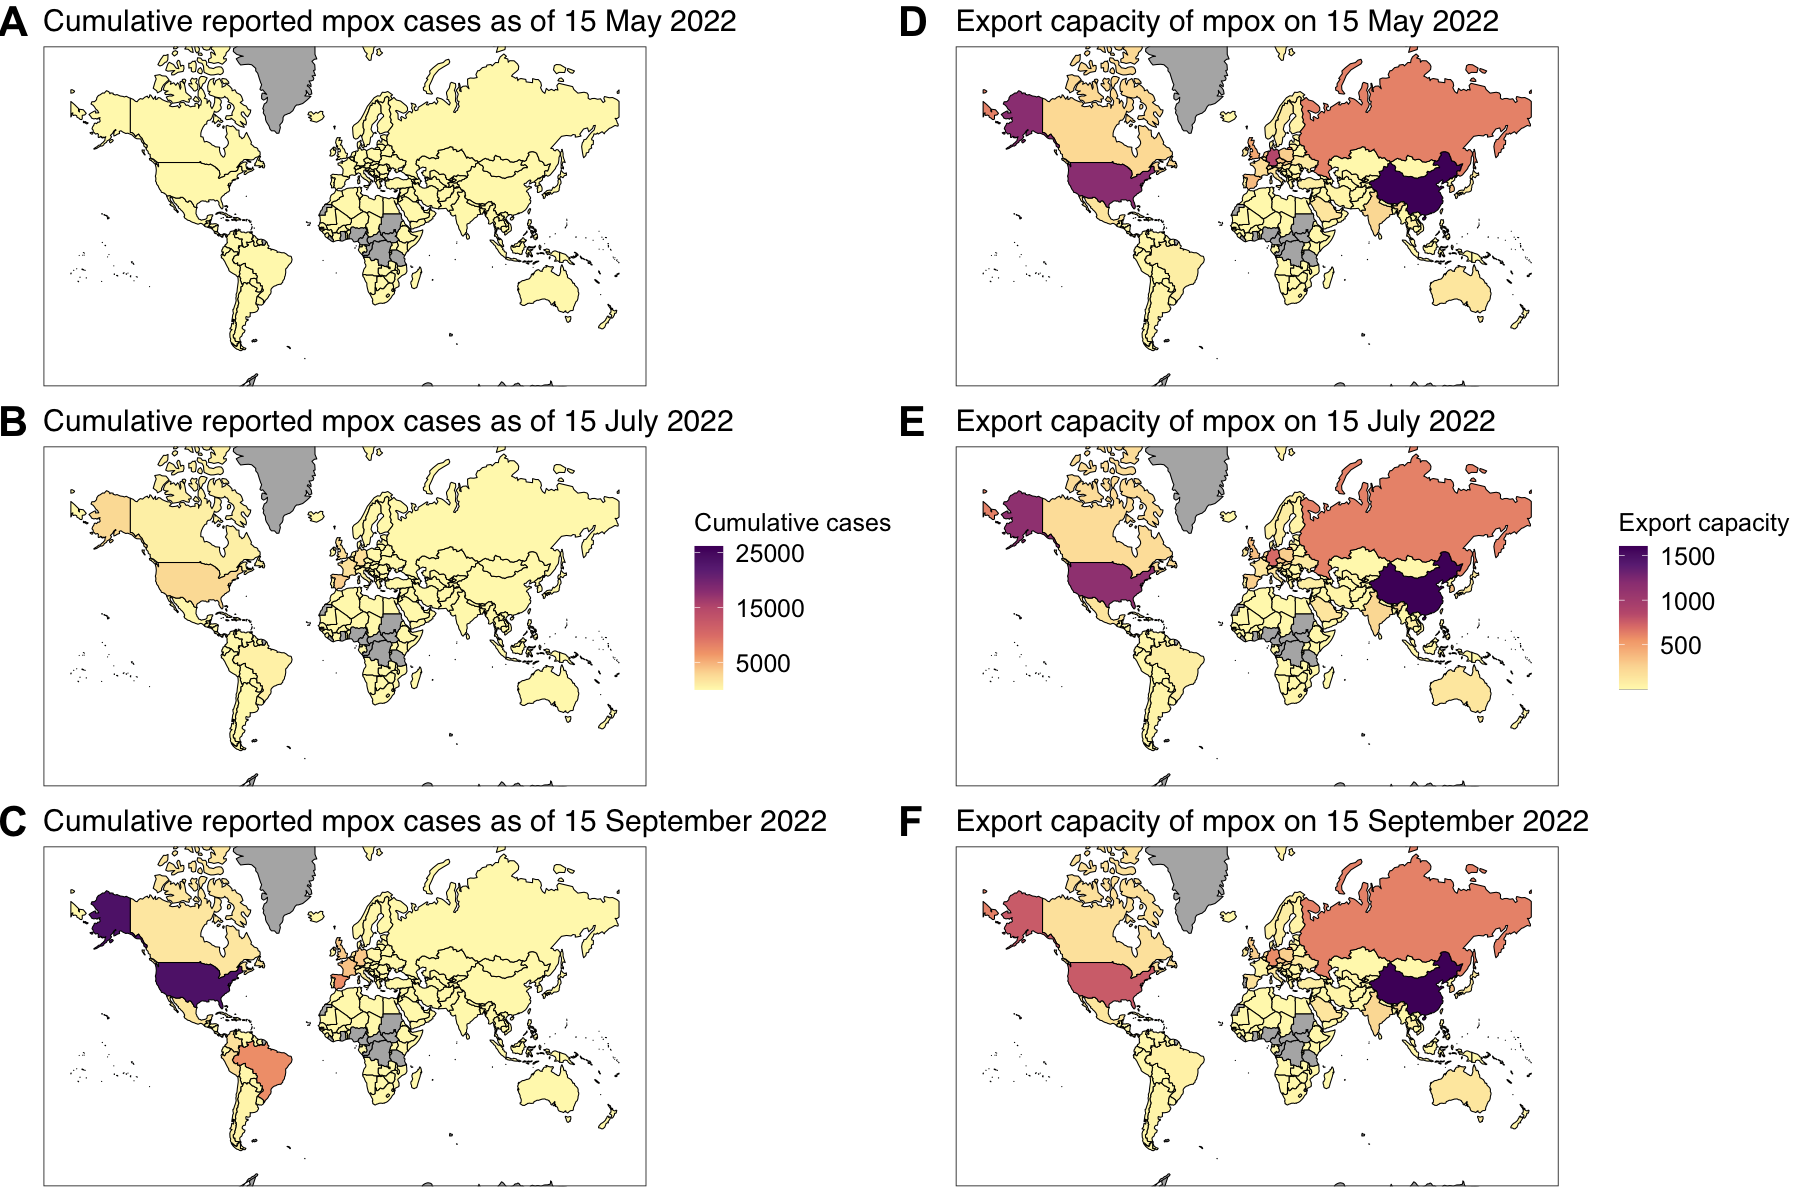

In [245]:
options(repr.plot.width=15,repr.plot.height=10)
ggarrange(Fig_cumcase, Fig_export2, ncol = 2)

In [246]:
capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% 
                                     filter(SAR==0.2 & group==c("Europe") & date == as.Date("2022-05-15")) %>%
                                     dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
exporting_map_poly <- fortify(exporting_map)
exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
exporting_map_poly_EU2 <- exporting_map_poly %>% arrange(id, order)

capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% 
                                     filter(SAR==0.2 & group==c("Europe") & date == as.Date("2022-07-15")) %>%
                                     dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
exporting_map_poly <- fortify(exporting_map)
exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
exporting_map_poly_EU4 <- exporting_map_poly %>% arrange(id, order)

capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% 
                                     filter(SAR==0.2 & group==c("Europe") & date == as.Date("2022-09-15")) %>%
                                     dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
exporting_map_poly <- fortify(exporting_map)
exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
exporting_map_poly_EU6 <- exporting_map_poly %>% arrange(id, order)

Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


In [253]:
C_i_final_all %>% filter(SAR==0.2 & group==c("Europe")) -> C_i_figure_EU

scale_set <- scales::rescale(c(0, 1000, 2000, 3000, 4000, 5000, 6000, max(C_i_figure_EU$MA_total_cases)),
                       from = c(min(C_i_figure_EU$MA_total_cases), max(C_i_figure_EU$MA_total_cases)))
limit_set <- c(min(C_i_figure_EU$MA_total_cases), max(C_i_figure_EU$MA_total_cases))
colort_set <- c('#fff8ba', '#fcdba2', '#f4a77a', '#e18079', '#c35e7d', '#9b4283', '#6c2d83', "#4f0e69")
label_set = c("2000", "4000", "6000")
break_set = c(2000, 4000, 6000)

options(repr.plot.width=10,repr.plot.height=5)
ggplot() + 
  coord_quickmap(xlim = c(-25, 50),  ylim = c(35, 70)) +
  geom_polygon(data = exporting_map_poly_EU2, aes(long, lat, group = group, fill=MA_total_cases),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Cumulative cases", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Cumulative cases as of 15 May 2022 in Europe") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15May

ggplot() + 
  coord_quickmap(xlim = c(-25, 50),  ylim = c(35, 70)) +
  geom_polygon(data = exporting_map_poly_EU4, aes(long, lat, group = group, fill=MA_total_cases),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Cumulative cases", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Cumulative cases as of 15 July 2022 in Europe") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Jul

ggplot() + 
  coord_quickmap(xlim = c(-25, 50),  ylim = c(35, 70)) +
  geom_polygon(data = exporting_map_poly_EU6, aes(long, lat, group = group, fill=MA_total_cases),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Cumulative cases", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Cumulative cases as of 15 September 2022 in Europe") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep

library(ggpubr)
options(repr.plot.width=11,repr.plot.height=15)

ggarrange(Fig15May, Fig15Jul, Fig15Sep, 
          labels = c("A","B","C"), font.label = list(size = 25), vjust=1.2, hjust=0,
          ncol = 1, nrow = 3, common.legend = TRUE, legend="right") -> Fig_cumcase_EU

In [254]:
region_list <- unique(C_i_final_all$group)

options(repr.plot.width=5,repr.plot.height=5)
colort_set <- c('#fff8ba', '#fcdba2', '#f4a77a', '#e18079', '#c35e7d', '#9b4283', '#6c2d83', "#4f0e69")


C_i_final_all %>% filter(SAR==0.2 & group==c("Europe")) -> C_i_figure
scale_set <- scales::rescale(c(0, 150, 280, 380, 500, 600, 750, max(C_i_figure$C_i_t)),
                       from = c(min(C_i_figure$C_i_t), max(C_i_figure$C_i_t)))
limit_set <- c(min(C_i_figure$C_i_t), max(C_i_figure$C_i_t))
label_set = c("200", "400", "600", "800")
break_set = c(200, 400, 600, 800)

ggplot() + 
  coord_quickmap(xlim = c(-25, 50),  ylim = c(35, 70)) +
  geom_polygon(data = exporting_map_poly_EU2, aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Export capacity of mpox on 15 May 2022 in Europe") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 18), legend.text = element_text(size = 18)) -> Fig15May

ggplot() + 
  coord_quickmap(xlim = c(-25, 50),  ylim = c(35, 70)) +
  geom_polygon(data = exporting_map_poly_EU4, aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Export capacity of mpox on 15 July 2022 in Europe") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 18), legend.text = element_text(size = 18)) -> Fig15Jul

ggplot() + 
  coord_quickmap(xlim = c(-25, 50),  ylim = c(35, 70)) +
  geom_polygon(data = exporting_map_poly_EU6, aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("Export capacity of mpox on 15 September 2022 in Europe") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep

library(ggpubr)
options(repr.plot.width=20,repr.plot.height=15)
ggarrange(Fig15May, Fig15Jul, Fig15Sep, 
          labels = c("D","E","F"), font.label = list(size = 25), vjust=1.2, hjust=0,
          ncol = 1, nrow = 3, common.legend = TRUE, legend="right") -> Fig_export_EU

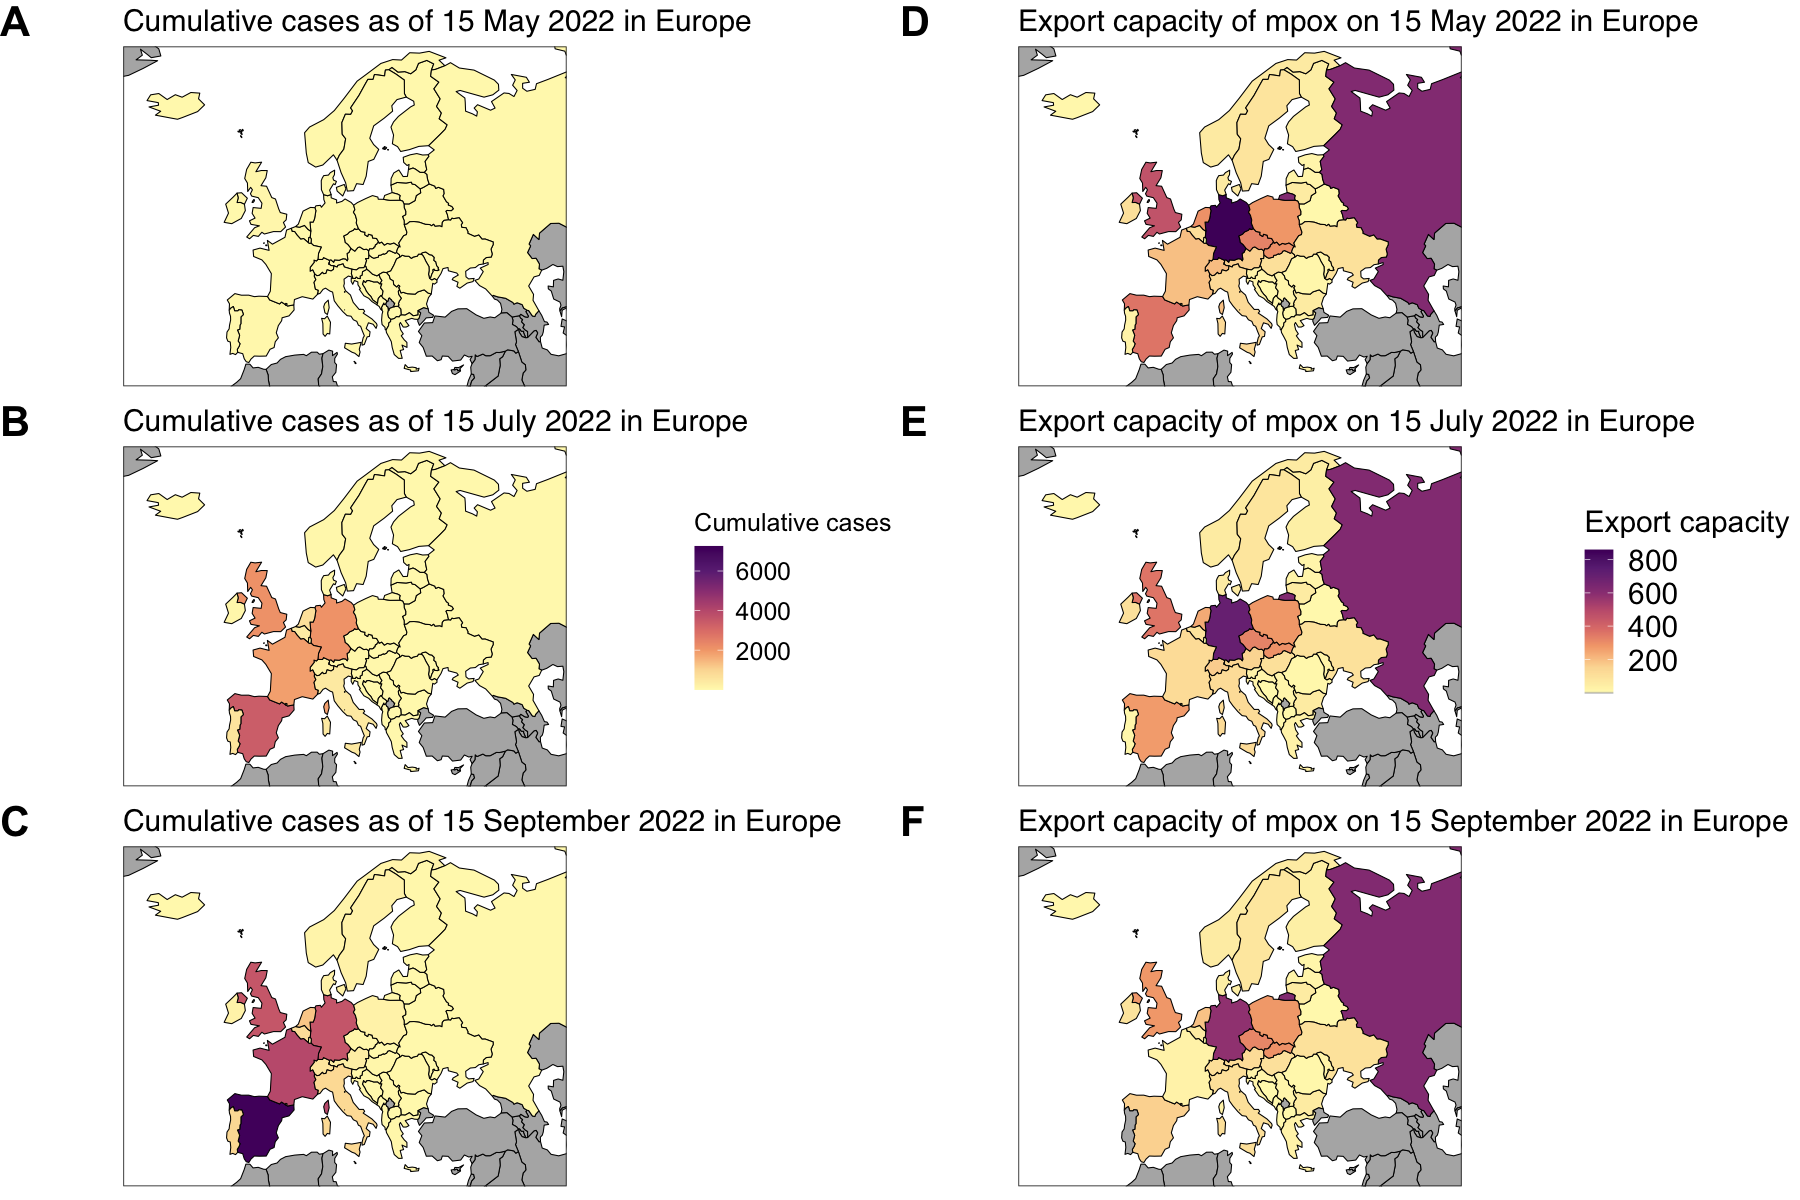

In [255]:
options(repr.plot.width=15,repr.plot.height=10)
ggarrange(Fig_cumcase_EU, Fig_export_EU, ncol = 2)

In [205]:
region_exporting_all <- list()

for(i in 1:length(SAR_list)){
    region_exporting <- list()

    capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% 
                                         filter(SAR==SAR_list[i] & date == as.Date("2022-05-15")) %>%
                                         dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
    exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
    exporting_map_poly <- fortify(exporting_map)
    exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
    exporting_map_poly %>% arrange(id, order) -> region_exporting[[1]]
    
    capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% 
                                         filter(SAR==SAR_list[i] & date == as.Date("2022-07-15")) %>%
                                         dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
    exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
    exporting_map_poly <- fortify(exporting_map)
    exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
    exporting_map_poly %>% arrange(id, order) -> region_exporting[[2]]
    
    capture.output(exporting_map <- joinCountryData2Map(C_i_final_all %>% 
                                         filter(SAR==SAR_list[i] & date == as.Date("2022-09-15")) %>%
                                         dplyr::select(-group), joinCode = "ISO3", nameJoinColumn = "iso_code", 
                                                    verbose=FALSE), file='NUL')
    exporting_map@data %<>% dplyr::select(-ISO_A3) %>% rename(ISO_A3=iso_code)
    exporting_map_poly <- fortify(exporting_map)
    exporting_map_poly <- merge(exporting_map_poly, exporting_map@data, by.x="id", by.y="ADMIN", all.x=T)
    exporting_map_poly %>% arrange(id, order) -> region_exporting[[3]]

    region_exporting -> region_exporting_all[[i]]
}

Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


In [259]:
C_i_final_all %>% filter(SAR==0.2) -> C_i_figure; C_i_final_all %>% filter(SAR==0.4) -> C_i_figure_temp

scale_set <- scales::rescale(c(0, 800, 1500, 2500, 3000, 3500, 4500, max(C_i_figure_temp$C_i_t)),
                       from = c(min(C_i_figure_temp$C_i_t), max(C_i_figure_temp$C_i_t)))
limit_set <- c(min(C_i_figure$C_i_t), max(C_i_figure_temp$C_i_t))
colort_set <- c('#fff8ba', '#fcdba2', '#f4a77a', '#e18079', '#c35e7d', '#9b4283', '#6c2d83', "#4f0e69")
label_set = c("2000", "4000")
break_set = c(2000, 4000)

options(repr.plot.width=10,repr.plot.height=5)
ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[2]][1]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 May 2022 (SAR=0.3)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15May_1

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[2]][2]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 July 2022 (SAR=0.3)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Jul_1

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[2]][3]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 September 2022 (SAR=0.3)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep_1

options(repr.plot.width=10,repr.plot.height=5)
ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[3]][1]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 May 2022 (SAR=0.4)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15May_2

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[3]][2]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 July 2022 (SAR=0.4)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Jul_2

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[3]][3]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 September 2022 (SAR=0.4)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep_2

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[1]][1]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 May 2022 (SAR=0.2)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15May_0

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[1]][2]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 July 2022 (SAR=0.2)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Jul_0

ggplot() + 
  coord_map(xlim = c(-180, 180), ylim = c(-60, 75))  +
  geom_polygon(data = as.data.frame(region_exporting_all[[1]][3]), 
               aes(long, lat, group = group, fill=C_i_t),size = 0.3, color = "black") + 
  scale_fill_gradientn(name="Export capacity", na.value = "grey70", limits=limit_set,
                       labels=label_set, breaks=break_set, values = scale_set, colours = colort_set) +
  theme_bw() + xlab(NULL) + ylab(NULL) +
  ggtitle("15 September 2022 (SAR=0.2)") + 
  theme(plot.title = element_text(size=18, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank(),
        legend.title = element_text(size = 15), legend.text = element_text(size = 15)) -> Fig15Sep_0

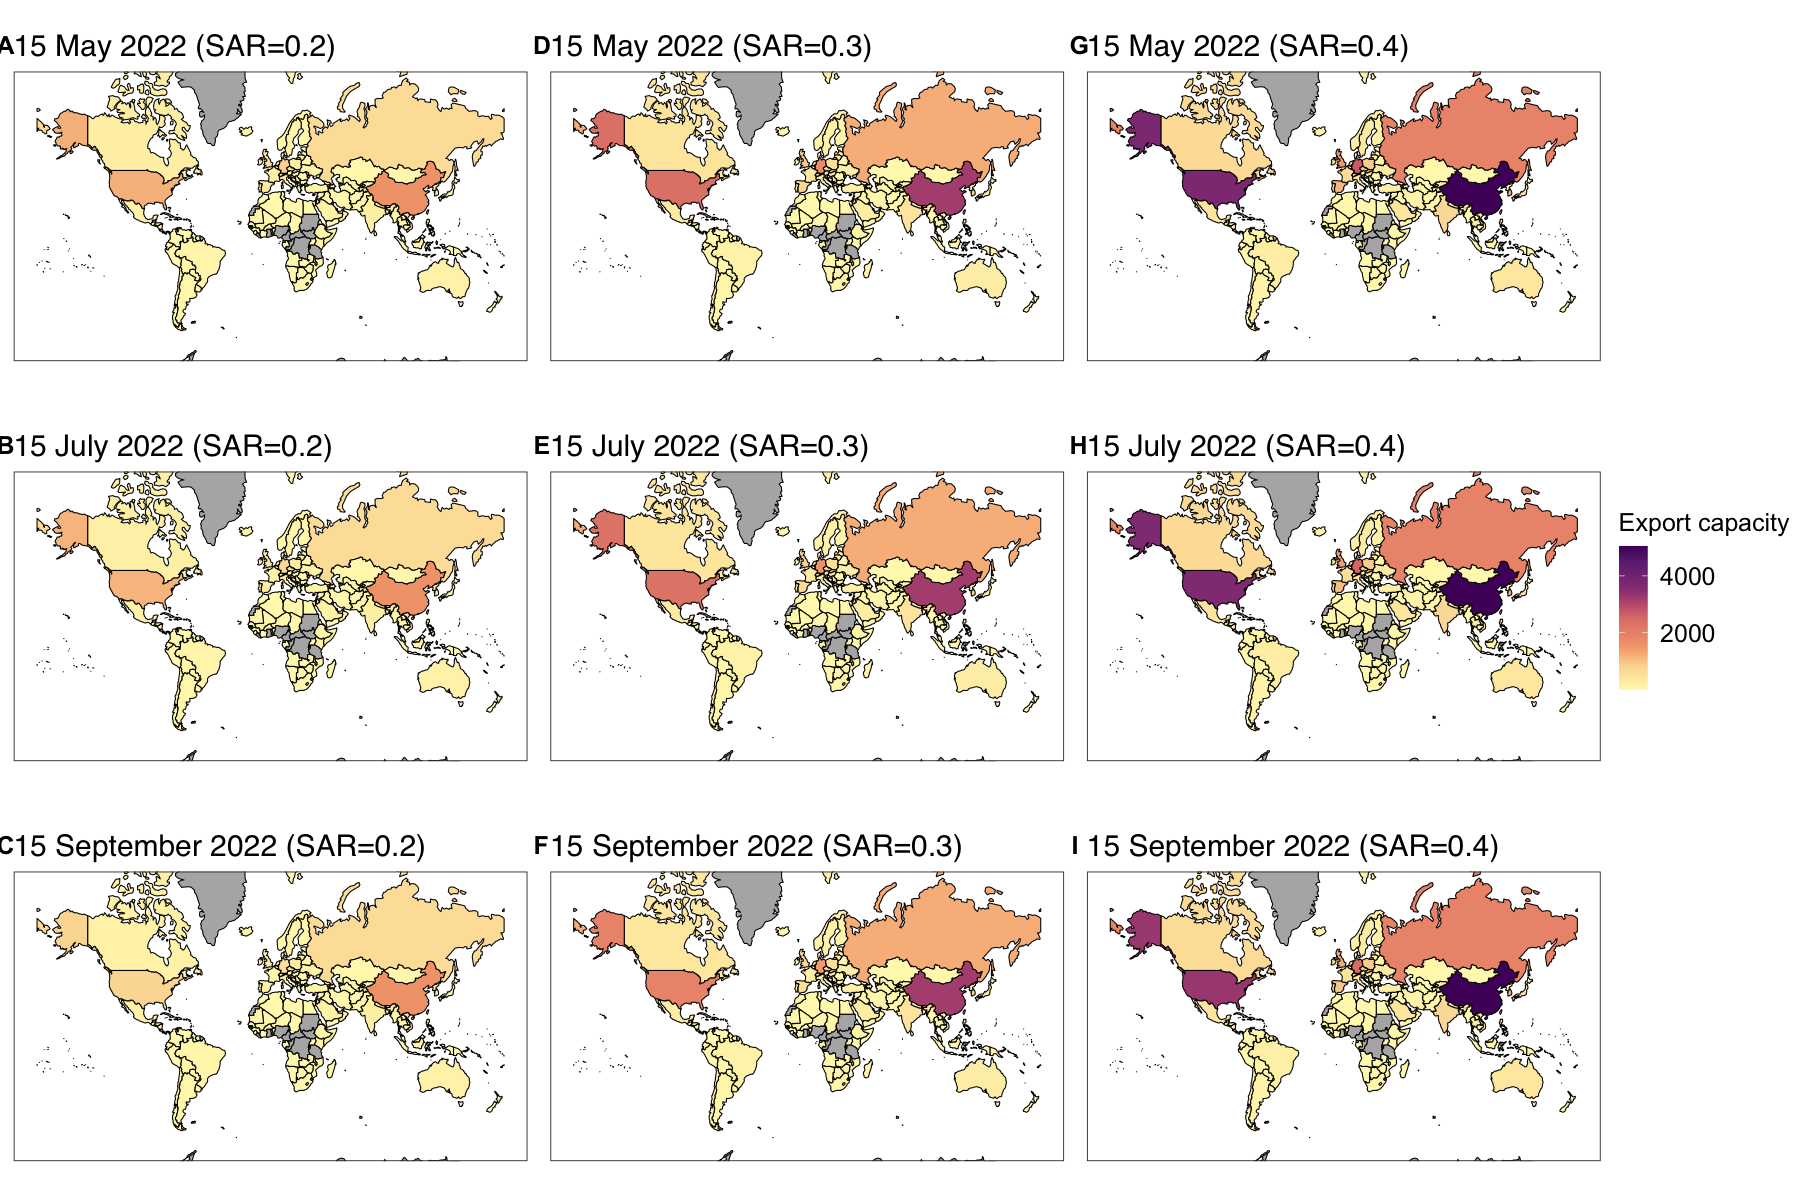

In [284]:
options(repr.plot.width=15,repr.plot.height=10)
ggarrange(Fig15May_0, Fig15May_1, Fig15May_2, Fig15Jul_0, Fig15Jul_1, Fig15Jul_2, Fig15Sep_0, Fig15Sep_1, Fig15Sep_2, 
          labels = c("A","D","G","B","E","H","C","F","I"), font.label = list(size = 15), vjust=3, hjust=0.18,
          ncol = 3, nrow = 3, common.legend = TRUE, legend="right") 